In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers, models, Input, callbacks
from IPython.display import display, HTML


In [62]:
import pandas as pd


class MQTTDataCleaner:
    def __init__(self, mqtt_csv_file):
        self.mqtt_csv_file = mqtt_csv_file
        self.cleaned_file = "outputs/dane_falownik.csv"
        self.pivoted_file = "outputs/dane_falownik_ustawienie_kolumn.csv"
        self.final_file = "outputs/dane_falownika_plus_roz_moc.csv"

    def load_and_clean(self):
        df = pd.read_csv(self.mqtt_csv_file, header=None, names=['timestamp', 'topic', 'value'])
        frazy = [
            'if0754/fca/m9', 'if0754/fca/m10', 'if0754/fca/m11',
            'if0754/fca/connected', 'if0754/fca/m12', 'if0754/connected'
        ]
        df['topic'] = df['topic'].astype(str).str.strip()
        df_filtered = df[~df['topic'].isin(frazy)]
        df_filtered.to_csv(self.cleaned_file, index=False)
        return df_filtered

    def pivot_and_rename(self):
        df = pd.read_csv(self.cleaned_file)
        df_pivot = df.pivot(index='timestamp', columns='topic', values='value')
        df2 = df_pivot.reset_index()
        df2.columns = ['timestamp', 'Napięcie Ua', 'Napięcie Ub', 'Napięcie Uc',
                       'Prąd Idc', 'Napięcie Udc', 'Moc chwilowa Pdc', 'Moc suma P ALL', 'SF']
        df2.to_csv(self.pivoted_file, index=False)
        return df2

    def resample_data(self):
        df = pd.read_csv(self.pivoted_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        df_resampled = df.resample('5min').max().reset_index()

        df_resampled['energia [kW/h]'] = df_resampled['Moc suma P ALL'].diff().round(4)
        df_resampled['energia [kW/h]'] = df_resampled['energia [kW/h]'].fillna(0)

        df_resampled["Moc P DC po SF"] = df_resampled.apply(self.przeskaluj, axis=1)
        df_resampled.to_csv(self.final_file, index=False)
        return df_resampled

    @staticmethod
    def przeskaluj(row):
        if row["SF"] == 65535.0:
            return row["Moc chwilowa Pdc"] / 10
        elif row["SF"] == 65534.0:
            return row["Moc chwilowa Pdc"] / 100
        elif row["SF"] == 65533.0:
            return row["Moc chwilowa Pdc"] / 1000
        else:
            return row["Moc chwilowa Pdc"]


In [64]:
import pandas as pd
import numpy as np


class DataMerger:
    def __init__(self, plik_falownik, plik_solcast):
        self.plik_falownik = plik_falownik
        self.plik_solcast = plik_solcast
        self.wynik_dopasowany = "outputs/dopasowane_finalnie.csv"
        self.wynik_treningowy = "outputs/dane_treningowe.csv"

    def dopasuj_i_przygotuj_dane(self):
        dane_falownik = pd.read_csv(self.plik_falownik)
        dane_solcast = pd.read_csv(self.plik_solcast)

        dane_falownik['timestamp'] = pd.to_datetime(dane_falownik['timestamp'])
        dane_falownik['timestamp'] = dane_falownik['timestamp'].dt.tz_localize('Europe/Warsaw').dt.tz_convert('UTC')
        dane_solcast['period_end'] = pd.to_datetime(dane_solcast['period_end'], utc=True)

        dane_falownik = dane_falownik.sort_values('timestamp')
        dane_solcast = dane_solcast.sort_values('period_end')

        dane_polaczone = pd.merge_asof(
            dane_falownik,
            dane_solcast[['period_end', 'ghi', 'air_temp']],
            left_on='timestamp',
            right_on='period_end',
            direction='nearest',
            tolerance=pd.Timedelta('3min')
        )

        print(f"Liczba niedopasowanych wierszy: {dane_polaczone['ghi'].isna().sum()}")

        dane_polaczone = dane_polaczone.reset_index(drop=True).set_index('timestamp')

        energia_15min = (
            dane_polaczone['energia [kW/h]']
            .resample('15min')
            .sum()
            .round(4)
            .to_frame(name='energia_15min [kWh]')
        )

        energia_15min['energia_15min [kWh]'] = energia_15min['energia_15min [kWh]'].clip(lower=0.0)
        energia_15min.loc[energia_15min['energia_15min [kWh]'] > 2.0, 'energia_15min [kWh]'] = 0.0

        dane_polaczone = dane_polaczone.join([energia_15min]).reset_index()

        dane_polaczone['hour_decimal'] = dane_polaczone['timestamp'].dt.hour + dane_polaczone['timestamp'].dt.minute / 60
        dane_polaczone['day_of_year'] = dane_polaczone['timestamp'].dt.dayofyear
        dane_polaczone['sin_hour'] = np.sin(2 * np.pi * dane_polaczone['hour_decimal'] / 24)
        dane_polaczone['cos_hour'] = np.cos(2 * np.pi * dane_polaczone['hour_decimal'] / 24)

        dane_polaczone.to_csv(self.wynik_dopasowany, index=False)

        dane_treningowe = dane_polaczone[
            (dane_polaczone['ghi'] >= 0) &
            (dane_polaczone['energia_15min [kWh]'].notna())
        ][[
            'timestamp', 'ghi', 'air_temp', 'sin_hour', 'cos_hour', 'day_of_year', 'energia_15min [kWh]'
        ]]

        dane_treningowe.to_csv(self.wynik_treningowy, index=False)

        return dane_treningowe


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks
import joblib
import matplotlib.pyplot as plt


class ModelTrainer:
    def __init__(self, df):
        self.df = df
        self.model = None
        self.scaler = StandardScaler()

    def przygotuj_cechy_i_etykiety(self):
        X = self.df[["ghi", "air_temp", "sin_hour", "cos_hour"]].values
        y = self.df["energia_15min [kWh]"].values
        return X, y

    def skaluj_dane(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, y_train, y_test

    def zbuduj_model(self):
        self.model = models.Sequential([
            Input(shape=(4,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    def trenuj(self, X_train, y_train, X_test, y_test):
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.historia = self.model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stop]
        )

    def ocen_model(self, X_test, y_test):
        y_test_pred = self.model.predict(X_test).flatten()

        mae = mean_absolute_error(y_test, y_test_pred)
        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_test_pred)

        print(f"MAE: {mae:.3f} kWh")
        print(f"RMSE: {rmse:.3f} kWh")
        print(f"R²: {r2:.3f}")

    def zapisz_model_i_scaler(self):
        self.model.save('models/model_trained.keras')
        joblib.dump(self.scaler, "models/scaler_produkcji.pkl")
        print("Model i scaler zapisane.")

    def wykres_uczenia(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.historia.history['loss'], label='Strata treningowa')
        plt.plot(self.historia.history['val_loss'], label='Strata walidacyjna')
        plt.xlabel('Epoka')
        plt.ylabel('MSE')
        plt.title('Postęp uczenia się modelu')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run(self):
        X, y = self.przygotuj_cechy_i_etykiety()
        X_train, X_test, y_train, y_test = self.skaluj_dane(X, y)
        self.zbuduj_model()
        self.trenuj(X_train, y_train, X_test, y_test)
        self.ocen_model(X_test, y_test)
        self.wykres_uczenia()
        self.zapisz_model_i_scaler()


In [68]:
import pandas as pd
import numpy as np
from tensorflow import keras
import joblib


class Predictor:
    def __init__(self, model_path, scaler_path):
        self.model = keras.models.load_model(model_path)
        self.scaler = joblib.load(scaler_path)

    def prepare_features(self, df_forecast):
        df = df_forecast.copy()
        df['period_end'] = pd.to_datetime(df['period_end'])
        df['hour'] = df['period_end'].dt.hour + df['period_end'].dt.minute / 60
        df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

        features = df[['ghi', 'air_temp', 'sin_hour', 'cos_hour']].values
        scaled = self.scaler.transform(features)

        return df, scaled

    def predict(self, df_forecast):
        df, X_scaled = self.prepare_features(df_forecast)
        y_pred = self.model.predict(X_scaled).flatten()
        y_pred = np.maximum(y_pred, 0)
        df['energia_15min_pred [kWh]'] = np.round(y_pred, 4)

        return df

    def save_prediction(self, df, filename="outputs/prognoza_z_predykcja.csv"):
        df.to_csv(filename, index=False)

    def agreguj_dziennie(self, df):
        df['data'] = df['period_end'].dt.date
        suma_dzienna = (
            df.groupby('data')['energia_15min_pred [kWh]']
            .sum()
            .reset_index()
            .rename(columns={'energia_15min_pred [kWh]': 'energia_dzienna_pred [kWh]'})
        )
        suma_dzienna.to_csv("outputs/prognoza_suma_dzienna.csv", index=False)
        return suma_dzienna


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML


class Visualizer:
    def __init__(self):
        pass

    def plot_daily(self, df, target_date):
        df['period_end'] = pd.to_datetime(df['period_end'], utc=True).dt.tz_convert('Europe/Warsaw')

        start = pd.Timestamp(target_date + ' 00:00').tz_localize('Europe/Warsaw')
        end = start + pd.Timedelta(days=1)
        df_day = df[(df['period_end'] >= start) & (df['period_end'] < end)].copy()

        df_day['moc_chwilowa [kW]'] = df_day['energia_15min_pred [kWh]']

        hours = pd.date_range(
            start=df_day['period_end'].min().ceil('h'),
            end=df_day['period_end'].max().floor('h'),
            freq='1h'
        )

        results = []
        for hour in hours:
            mask = (df_day['period_end'] > hour - pd.Timedelta(minutes=30)) & \
                   (df_day['period_end'] <= hour + pd.Timedelta(minutes=30))
            fragment = df_day.loc[mask].sort_values('period_end')
            if len(fragment) >= 4:
                suma = fragment['moc_chwilowa [kW]'].iloc[:4].sum()
                results.append({'period_end': hour, 'moc_1h_sum [kW]': suma})

        df_hourly = pd.DataFrame(results)

        suma_energii = df_day['energia_15min_pred [kWh]'].sum()
        print(f"Prognozowana suma produkcji energii {target_date}: {suma_energii:.2f} kWh")

        plt.figure(figsize=(12, 6))
        plt.plot(df_day['period_end'], df_day['moc_chwilowa [kW]'], marker='o', linestyle='-', label='Co 15 min')
        if not df_hourly.empty:
            plt.bar(df_hourly['period_end'], df_hourly['moc_1h_sum [kW]'], width=0.03, label='Suma 1h (4×)')
        else:
            print("Brak danych do słupków.")
        plt.title(f'Produkcja PV – {target_date}')
        plt.xlabel('Czas')
        plt.ylabel('Moc [kW]')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        if not df_hourly.empty:
            max_moc = df_hourly['moc_1h_sum [kW]'].max()
            print(f'Maksymalna suma 1h: {max_moc:.2f} kW')
        else:
            print("Nie obliczono sum godzinnych.")

        display(HTML(f"<span style='color: black; font-size: 20px; font-weight: bold;'>Suma energii prognozowanej {target_date}: {suma_energii:.2f} kWh</span>"))


🚀 Start procesu...
Liczba niedopasowanych wierszy: 2633
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0897 - mae: 0.2162 - val_loss: 0.0236 - val_mae: 0.1075
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - mae: 0.1043 - val_loss: 0.0171 - val_mae: 0.0821
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - mae: 0.1012 - val_loss: 0.0154 - val_mae: 0.0792
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - mae: 0.0841 - val_loss: 0.0137 - val_mae: 0.0726
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - mae: 0.0772 - val_loss: 0.0136 - val_mae: 0.0642
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - mae: 0.0687 - val_loss: 0.0128 - val_mae: 0.0615
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0156 - mae: 0.0668 - val_loss: 0.0120 - val_mae: 0.0704
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - mae: 0.0759 - val_loss: 0.0126 - val_mae: 0.0576
Epoch 9

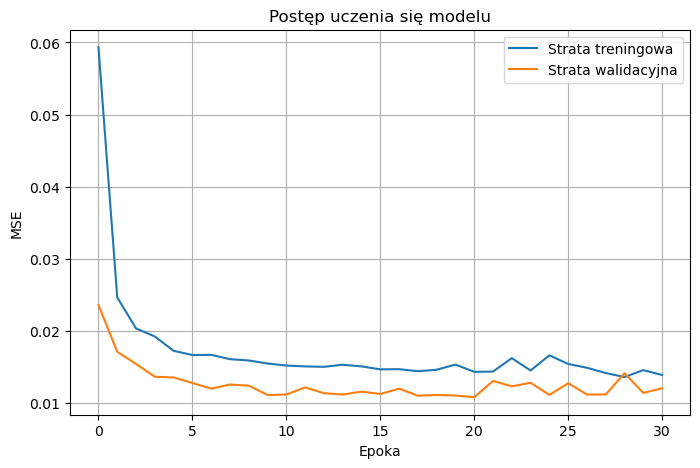

Model i scaler zapisane.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Prognozowana suma produkcji energii 2025-06-18: 29.69 kWh


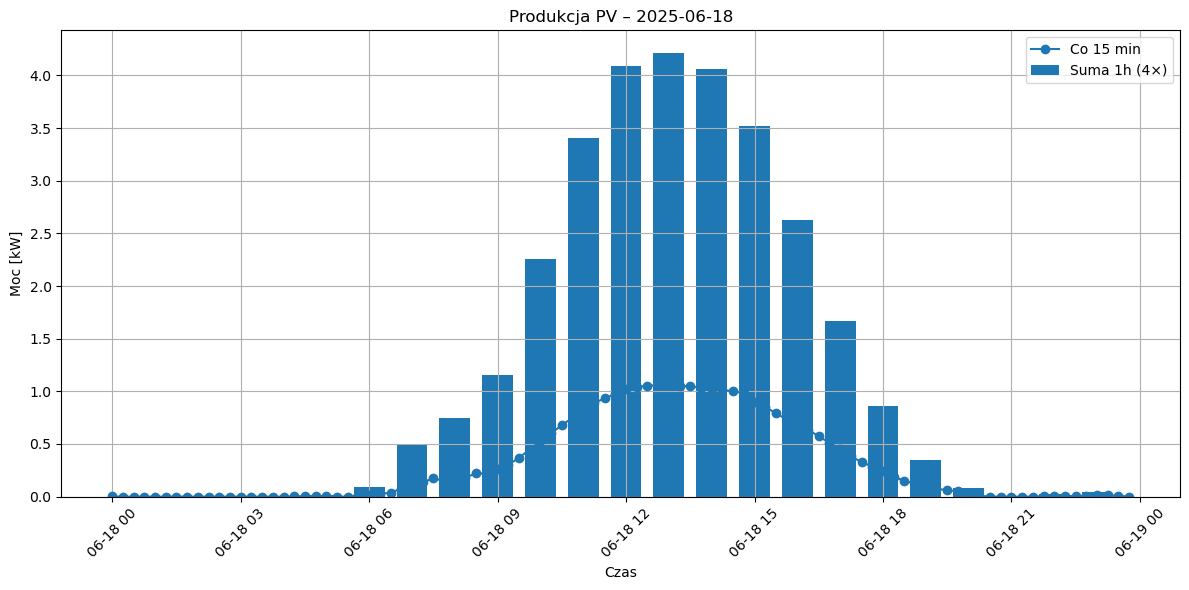

Maksymalna suma 1h: 4.22 kW


✅ Proces zakończony pomyślnie.


In [95]:
from data_cleaner import MQTTDataCleaner
from data_merger import DataMerger
from model_trainer import ModelTrainer
from predictor import Predictor
from visualizer import Visualizer
import pandas as pd


def main():
    print("🚀 Start procesu...")

    # 1. Czyszczenie danych MQTT
    cleaner = MQTTDataCleaner("data/mqtt_data.csv")
    cleaner.load_and_clean()
    cleaner.pivot_and_rename()
    cleaner.resample_data()

    # 2. Łączenie z prognozą Solcast
    merger = DataMerger("outputs/dane_falownika_plus_roz_moc.csv", "data/solcast_history.csv")
    dane_treningowe = merger.dopasuj_i_przygotuj_dane()

    # 3. Trenowanie modelu
    trener = ModelTrainer(dane_treningowe)
    trener.run()

    # 4. Predykcja na danych prognozowanych
    predictor = Predictor("models/model_trained.keras", "models/scaler_produkcji.pkl")
    forecast = pd.read_csv("data/solcast_forecast.csv")
    prediction = predictor.predict(forecast)
    predictor.save_prediction(prediction)
    predictor.agreguj_dziennie(prediction)

    # 5. Wizualizacja dla wybranego dnia
    viz = Visualizer()
    viz.plot_daily(prediction, target_date="2025-06-18")

    print("✅ Proces zakończony pomyślnie.")


if __name__ == "__main__":
    main()


In [93]:
df_falownik = pd.read_csv("outputs/dane_falownika_plus_roz_moc.csv")
df_solcast = pd.read_csv("data/solcast_history.csv")

print("Falownik daty:", df_falownik['timestamp'].min(), "→", df_falownik['timestamp'].max())
print("Solcast daty:", df_solcast['period_end'].min(), "→", df_solcast['period_end'].max())


Falownik daty: 2025-05-30 07:30:00 → 2025-06-10 07:50:00
Solcast daty: 2025-05-28 20:15:00+00:00 → 2025-06-04 20:15:00+00:00
